In [34]:
import rebound
import numpy as np
import matplotlib.pyplot as plt

In [35]:
'''Set-Up Initial Conditions'''
def setupSimulation():
    sim = rebound.Simulation()
    sim.integrator = 'ias15'
    sim.units = ('yr','au','solarmass')
    smass = 1.0 #in Solar Mass units
    jmass = 0.000954588 #Jupiter Mass in Solar Mass units
    delta_critical = 2.40*((jmass + jmass)**(1./3.))
    sim.add(m = smass)
    sim.add(m = jmass, a= 1, r = (0.000477895/8), f = 0, hash="planet1")
    sim.add(m = jmass, a= (1 + delta_critical) - 0.0051, r = (0.000477895/8), f = np.pi, hash="planet2")
    sim.move_to_com()
    return sim

3 particles in the simulation at t = 0.0 yr
Protoplanet 1 Semi-Major Axis: 1.0 AU
Protoplanet 2 Semi-Major Axis: 1.2926327191589924 AU
Period of Protoplanet 1: 0.9995419250229012 yr
Period of Protoplanet 2: 1.4682727615251652 yr
True Anomaly of Protoplanet 1: 0.0 radians
True Anomaly of Protoplanet 2: 3.141592653589793 radians


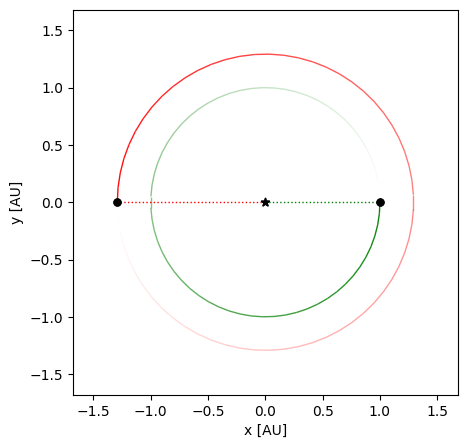

In [36]:
'''Conditions before collision'''
sim = setupSimulation()
tmax = 1e4

period1 = np.array([i.P for i in sim.calculate_orbits()])
omega1 = np.array([i.omega for i in sim.calculate_orbits()])
ecc = np.array([i.e for i in sim.calculate_orbits()])
p1 = period1[0]
p2 = period1[1]
f1 = omega1[0]
f2 = omega1[1]

print(f'{sim.N} particles in the simulation at t = {sim.t} yr')
print(f"Protoplanet 1 Semi-Major Axis: {sim.calculate_orbits()[0].a} AU")
print(f"Protoplanet 2 Semi-Major Axis: {sim.calculate_orbits()[1].a} AU")
print(f'Period of Protoplanet 1: {p1} yr')
print(f'Period of Protoplanet 2: {p2} yr')
print(f"True Anomaly of Protoplanet 1: {f1} radians")
print(f"True Anomaly of Protoplanet 2: {f2} radians")

fig = rebound.OrbitPlot(sim, unitlabel='[AU]', color=['green', 'red'], periastron=True)

In [37]:
'''Collision Resolve Function to count the number of close encounters'''
def close_encounter(sim_pointer, collision):
    global count
    global temp
    sim = sim_pointer.contents
    temp = temp + 1
    count = np.append(count, temp)
    return 0

Number of Close Encounters: [    0     1     2 ... 35522 35523 35524]


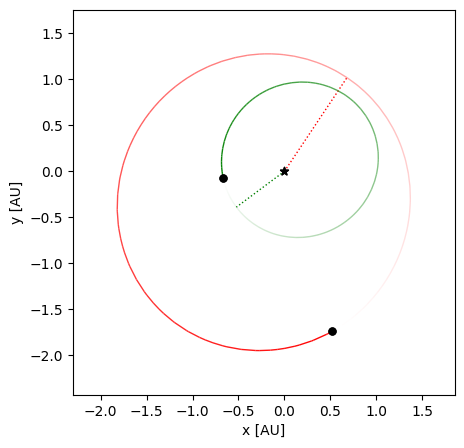

In [38]:
sim = setupSimulation()
temp = 0
count = np.array([0])
sim.collision = "direct"
sim.collision_resolve = close_encounter
sim.integrate(tmax)
print(f"Number of Close Encounters: {count}")
fig = rebound.OrbitPlot(sim, unitlabel='[AU]', color=['green', 'red'], periastron=True)

In [39]:
'''Merge Function'''
def my_merge(sim_pointer, collided_particles_index):
    global simulation_time
    sim = sim_pointer.contents 
    i = collided_particles_index.p1  
    j = collided_particles_index.p2 

    simulation_time = sim.t
    print(f"First Collision Occurs at time: {simulation_time} yr")
    total_mass = sim.particles[i].m + sim.particles[j].m
    merged_planet = (sim.particles[i] * sim.particles[i].m + sim.particles[j] * sim.particles[j].m)/total_mass 
    merged_radius = (sim.particles[i].r**3 + sim.particles[j].r**3)**(1/3)

    sim.particles[i] = merged_planet   
    sim.particles[i].m = total_mass    
    sim.particles[i].r = merged_radius 
    
    return 2

First Collision Occurs at time: 695.58849481873 yr


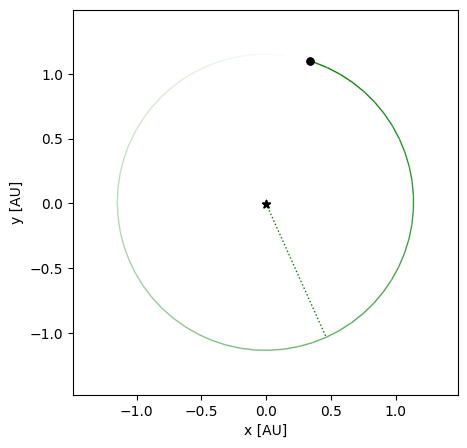

In [40]:
'''Merge Condition'''
sim = setupSimulation()
sim.collision = 'direct'
sim.collision_resolve = my_merge
sim.integrate(tmax)

period2 = np.array([i.P for i in sim.calculate_orbits()])
eccentricity = np.array([i.e for i in sim.calculate_orbits()])

fig = rebound.OrbitPlot(sim, unitlabel='[AU]', color=['green', 'red'], periastron=True)

Coordinates of Planet 1: (-0.6776878090386396, -0.9270622927860976)
Coordinates of Planet 2: (-0.6579834677968843, -0.9090421870512735)
Velocity Vector of Planet 1: <5.500119787177345, -2.7758490180585422>
Velocity Vector of Planet 2: <4.1064456826683635, -4.080526050011183>
Eccentricity of Orbit 1: 0.19522498892983461
Eccentricity of Orbit 2: 0.16170877852625953
SMA of Orbit 1: 1.291486401770626
SMA of Orbit 2: 1.0734240188526896


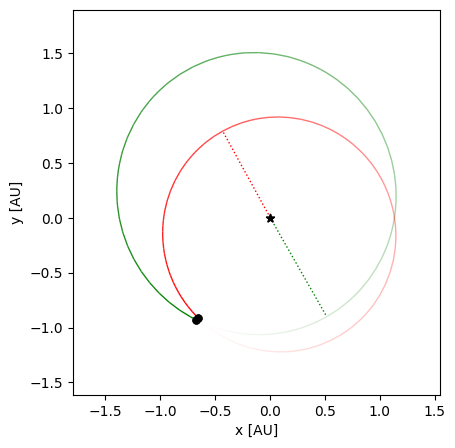

In [68]:
sim = setupSimulation()
sim.integrate(695.58)
fig = rebound.OrbitPlot(sim, unitlabel='[AU]', color=['green', 'red'], periastron=True)
p1 = sim.particles["planet1"]
p2 = sim.particles["planet2"]
print(f'Coordinates of Planet 1: ({p1.x}, {p1.y})')
print(f'Coordinates of Planet 2: ({p2.x}, {p2.y})')
print(f'Velocity Vector of Planet 1: <{p1.vx}, {p1.vy}>')
print(f'Velocity Vector of Planet 2: <{p2.vx}, {p2.vy}>')
print(f'Eccentricity of Orbit 1: {sim.calculate_orbits()[0].e}')
print(f'Eccentricity of Orbit 2: {sim.calculate_orbits()[1].e}')
print(f'SMA of Orbit 1: {sim.calculate_orbits()[0].a}')
print(f'SMA of Orbit 2: {sim.calculate_orbits()[1].a}')

In [69]:
print(sim.calculate_orbits()[0])
print(sim.calculate_orbits()[1])

<rebound.Orbit instance, a=1.291486401770626 e=0.19522498892983461 inc=0.0 Omega=0.0 omega=5.231170934677527 f=5.1331742159790625>
<rebound.Orbit instance, a=1.0734240188526896 e=0.16170877852625953 inc=0.0 Omega=0.0 omega=2.071809074769835 f=2.014045202203981>


In [70]:
def setupSimulation2():
    sim = rebound.Simulation()
    sim.integrator = 'ias15'
    sim.units = ('yr','au','solarmass')
    smass = 1.0 #in Solar Mass units
    jmass = 0.000954588 #Jupiter Mass in Solar Mass units
    sim.add(m = smass)
    sim.add(m = jmass, a= 1.291486401770626, e=0.19522498892983461, omega=5.231170934677527, r = (0.000477895), f = 5.1331742159790625)
    sim.add(m = jmass, a=1.0734240188526896, e=0.16170877852625953, omega=2.071809074769835, f=2.014045202203981, r = 0.000477895)
    sim.move_to_com()
    return sim

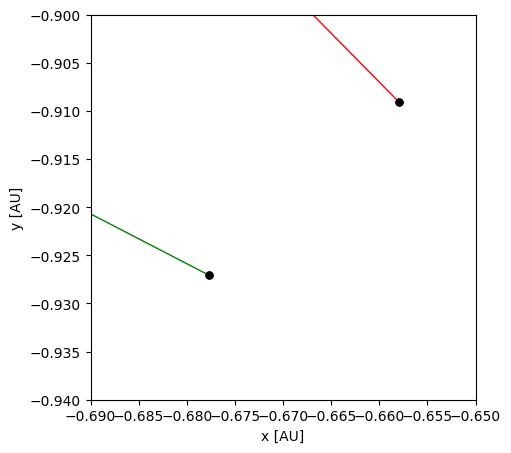

In [71]:
sim = setupSimulation2()
fig = rebound.OrbitPlot(sim, unitlabel='[AU]', color=['green', 'red'], periastron=True, xlim = [-0.69, -0.65], ylim= [-0.94, -0.9])